In [1]:
# Import the necessary packages and data
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)

In [2]:
times = []
for i in wq_df['Sample Time']:
    try:
        times.append(datetime.strptime(i, '%I:%M%p').time())
    except:
        times.append(np.nan)
wq_df['Sample Time'] = times

There are multiple dissolved oxygen measurements and 7 columns that do not start being measured until 2005. I am going to drop those columns as well.

In [3]:
drop_cols =  ['Winkler Method Top Dissolved Oxygen (mg/L)',  
              'Winkler Method Bottom Dissolved Oxygen (mg/L)', 
              'Percentage O2 Saturation Top Sample',  
              'Percentage O2 Saturation Bottom sample',
              'Total Phosphorus(mg/L)',
              'Top Nitrate/Nitrite (mg/L)'
             ]
for col in wq_df:
    observation_df = wq_df[wq_df[col].notnull()]
    if observation_df['Sample Date'].min().year > 2002:
        drop_cols.append(col)
wq_df = wq_df.drop(columns=drop_cols)

I will now examine the descriptive statistics of each column to identify values that are unexpectedly high or low.

In [4]:
wq_df_int = wq_df.select_dtypes(exclude=['object', 'datetime'])
wq_df_int_subset = wq_df_int.iloc[:, :10]
wq_df_int_subset.describe()

,Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),Top Salinity (psu),Bottom Salinity (psu),Top Conductivity (S/m),Bottom Conductivity (S/m),"CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)"
count,18996.000000,17733.000000,27886.000000,18939.000000,17836.000000,18968.000000,17720.000000,18758.000000,17528.000000,16217.000000
mean,18.703483,18.002141,28.630030,3.380010,32.244005,22.866737,24.809579,3.837574,4.090200,6.851332
std,6.801709,6.523780,21.298745,0.749955,20.358388,5.269741,3.794550,4.396670,4.665498,2.871964
min,-1.740000,-1.870000,0.020000,0.700000,1.000000,0.120000,0.200000,0.020000,0.000000,-1.120000
25%,15.737500,15.000000,14.000000,3.000000,17.000000,21.160000,23.060000,2.730000,2.980000,5.080000
50%,21.190000,20.340000,21.000000,3.000000,25.000000,24.060000,25.240000,3.370000,3.500000,6.410000
75%,23.570000,22.830000,40.000000,4.000000,43.000000,26.220000,27.270000,3.820000,3.900000,8.080000
max,30.010000,29.230000,230.000000,12.000000,107.000000,34.760000,44.730000,43.960000,62.560000,28.560000


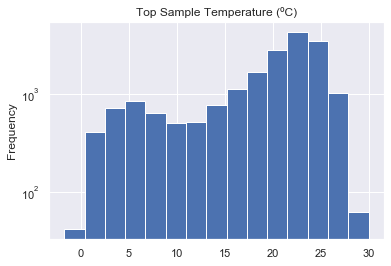

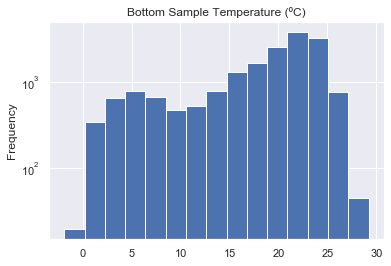

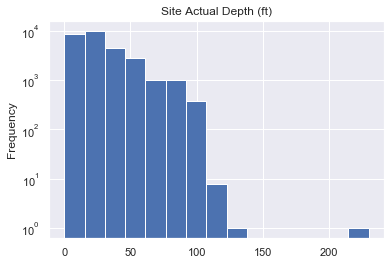

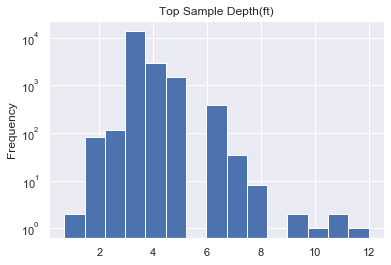

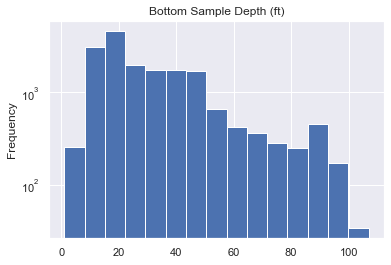

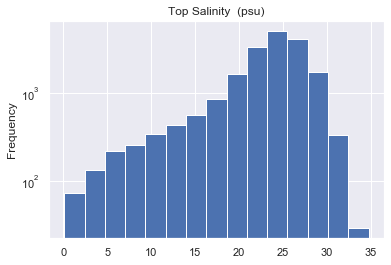

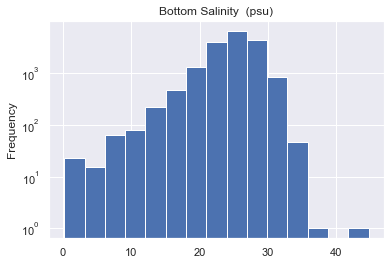

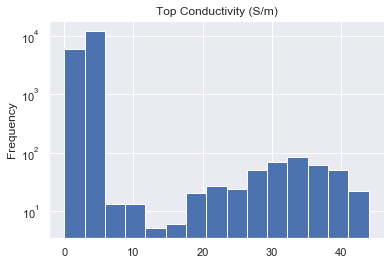

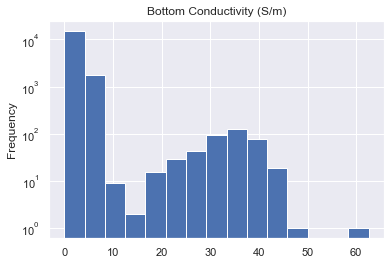

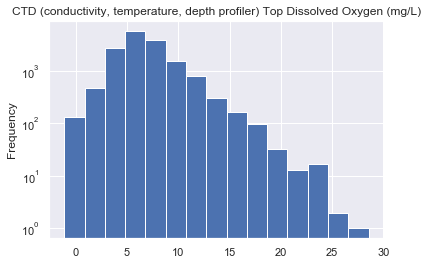

In [5]:
for col in wq_df_int_subset:
    _ = plt.figure()
    _ = wq_df_int[col].plot(kind='hist', bins=15)
    _ = plt.yscale('log')
    _ = plt.title(col)
    _ = plt.show()

- Columns with Questionable Values:
Site Actual Depth (max), Bottom Salinity (max), Bottom Conductivity (max)

In [6]:
wq_df.nlargest(5, 'Site Actual Depth (ft)')

,Sampling Location,Sample Date,Sample Time,Weather Condition (Dry or Wet),Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),Top Salinity (psu),...,Top Ortho-Phosphorus (mg/L),Top Total Kjeldhal Nitrogen (mg/L),Top Silica (mg/L),Total Phosphorus(mg/L),Top Total Suspended Solid (mg/L),Bottom Total Suspended Solid (mg/L),Top Active Chlorophyll 'A' (µg/L),Top Dissolved Organic Carbon (mg/L),Long,Lat
26577,E6,2018-05-24,13:05:00,D,15.18,13.95,230.0,3.0,19.0,22.39,...,0.087,0.786,1.086,0.165,8.00,8.0,3.38,2.82,-73.860830,40.78550
26153,NC2,2018-06-05,09:52:00,D,18.19,17.77,129.0,3.0,16.0,21.04,...,0.092,1.234,2.340,0.237,11.00,19.0,10.00,3.01,-73.935500,40.72883
24454,E8,2019-04-03,10:52:00,D,NaN,NaN,120.2,NaN,NaN,NaN,...,0.032,0.304,0.836,0.054,5.00,NaN,2.78,2.21,-73.820500,40.80500
24741,E8,2019-03-06,11:17:00,D,NaN,NaN,120.0,NaN,NaN,NaN,...,0.032,0.560,0.161,0.101,8.00,NaN,36.20,2.23,-73.820500,40.80500
18105,E8,2007-03-19,11:28:00,W,2.51,1.57,114.0,3.0,107.0,24.59,...,0.060,0.812,0.910,0.114,5.75,5.0,12.30,3.66,-73.783667,40.80050


The max depth is almost twice as high as the next deepest location and is the only depth measurement from site `E6`. It is safe to assume that this point is an erroneous entry. After more exploration, it is clear that there was a decimal point was misplaced. The depth should be 23.0 not 230.

In [7]:
wq_df.at[26577, 'Site Actual Depth (ft)'] = 23.0

In [8]:
wq_df.nlargest(10, 'Bottom Salinity  (psu)')['Bottom Salinity  (psu)']

17051    44.73
19630    36.12
19157    35.34
202      35.23
19198    34.94
6455     34.78
3666     34.65
18527    34.62
5112     34.57
7096     34.30
Name: Bottom Salinity  (psu), dtype: float64

While the maximum Bottom Salinity value is high, it does not appear to be an input error so I will keep it.

In [9]:
wq_df.nlargest(10, 'Bottom Conductivity (S/m)')['Bottom Conductivity (S/m)']

17051    62.56
202      49.38
17208    43.66
22574    43.59
21503    43.47
11085    43.38
21788    43.32
72       43.04
2637     43.04
710      43.00
Name: Bottom Conductivity (S/m), dtype: float64

While the maximum Bottom Conductivity value is high, it does not appear to be an input error so I will keep it. It is from the same sampling event as the max Bottom Salinity value.

In [10]:
wq_df_int_subset = wq_df_int.iloc[:, 10:20]
wq_df_int_subset.describe()

,"CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)",Light Trans (% transparency) Top Sample,Light Trans (% transparency) Bottom Sample,Top Sigma-T (kg/m3),Bottom Sigma-T (kg/m3),Secchi Depth (ft),Top PH,Bottom PH,Top Fecal Coliform Bacteria (Cells/100mL),Top Enterococci Bacteria (Cells/100mL)
count,15022.000000,11998.000000,11036.000000,18558.000000,17365.000000,23022.000000,27625.000000,20673.000000,28862.000000,28903.000000
mean,5.937268,59.592174,58.885732,15.648450,17.274156,3.922993,7.649962,7.624497,2508.636096,463.049614
std,2.735208,21.562496,23.318782,4.181427,3.212789,1.872168,0.557454,0.574186,15523.986296,5052.267825
min,-3.670000,-22.860000,-13.470000,-2.720000,-2.590000,0.500000,0.330000,0.000000,0.000000,0.000000
25%,4.390000,50.985000,50.600000,14.130000,15.690000,3.000000,7.400000,7.400000,11.000000,2.000000
50%,5.630000,65.400000,66.680000,16.320000,17.410000,3.500000,7.620000,7.600000,50.000000,6.000000
75%,7.100000,73.960000,74.692500,18.110000,19.200000,5.000000,7.870000,7.830000,264.000000,32.000000
max,29.670000,131.730000,130.550000,38.940000,31.510000,28.500000,78.000000,75.000000,200000.000000,200000.000000


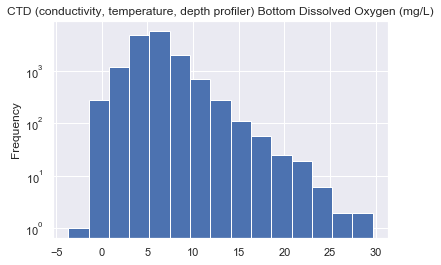

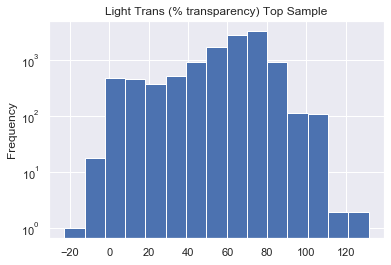

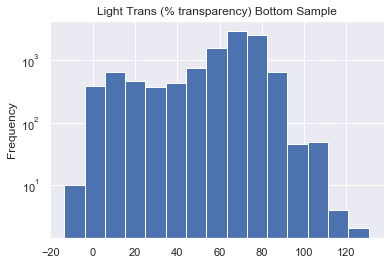

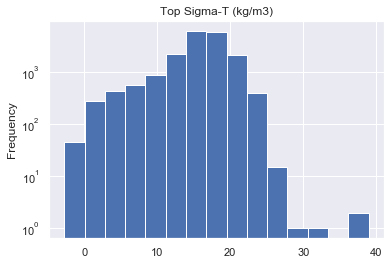

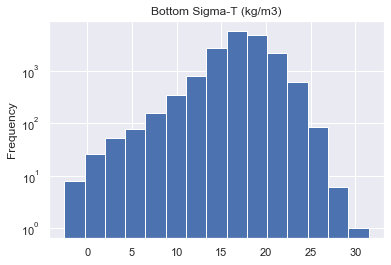

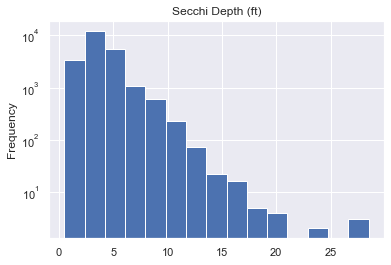

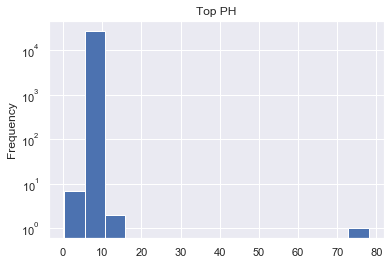

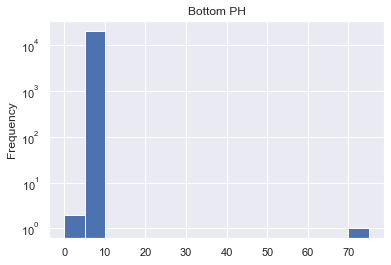

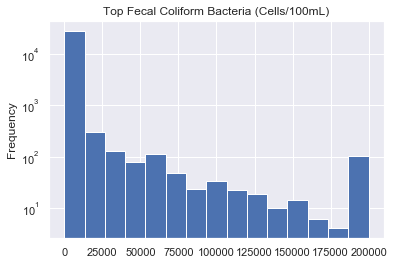

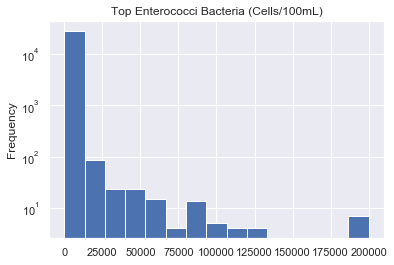

In [11]:
for col in wq_df_int_subset:
    _ = plt.figure()
    _ = wq_df_int[col].plot(kind='hist', bins=15)
    _ = plt.yscale('log')
    _ = plt.title(col)
    _ = plt.show()

- Questionable values:
Top sigma (max),  Top PH, Bottom PH

Despite being an exceedingly high measurement, dissolved oxygen can have wildly different values, so I will keep this outlier as well.

In [12]:
wq_df.nlargest(10, 'Top Sigma-T (kg/m3)')['Top Sigma-T (kg/m3)']

9413     38.94
23244    38.52
14813    33.20
4631     28.21
2403     27.17
18527    26.90
5112     26.62
6455     26.09
282      25.93
9736     25.82
Name: Top Sigma-T (kg/m3), dtype: float64

While high, these values appear to be outliers and not input errors.

In [13]:
wq_df.nlargest(5, 'Top PH')['Top PH']

25444    78.00
1032     11.34
11150    11.16
25683     9.52
20573     9.11
Name: Top PH, dtype: float64

In [14]:
wq_df.at[25444, 'Top PH'] = 7.80

In [15]:
wq_df.nlargest(10, 'Bottom PH')['Bottom PH']

25344    75.00
21549     8.96
16150     8.92
13185     8.90
3130      8.88
10778     8.85
26864     8.84
30593     8.84
18090     8.83
12230     8.82
Name: Bottom PH, dtype: float64

In [16]:
wq_df.at[25344, 'Bottom PH'] = 7.50

In [17]:
wq_df.nlargest(5, 'Top Enterococci Bacteria (Cells/100mL)')['Top Enterococci Bacteria (Cells/100mL)']

2907     200000.0
3423     200000.0
8761     200000.0
11484    200000.0
18824    200000.0
Name: Top Enterococci Bacteria (Cells/100mL), dtype: float64

Values don't appear to be errors.

In [18]:
wq_df_int_subset = wq_df_int.iloc[:, 20:30]
wq_df_int_subset.describe()

,Top Nitrate/Nitrite (mg/L),Top Ammonium (mg/L),Top Ortho-Phosphorus (mg/L),Top Total Kjeldhal Nitrogen (mg/L),Top Silica (mg/L),Total Phosphorus(mg/L),Top Total Suspended Solid (mg/L),Bottom Total Suspended Solid (mg/L),Top Active Chlorophyll 'A' (µg/L),Top Dissolved Organic Carbon (mg/L)
count,28602.000000,28574.000000,19297.000000,28533.000000,28507.000000,28554.000000,28503.000000,20709.000000,28474.000000,27732.000000
mean,0.388856,0.452576,0.165340,1.183278,2.151428,0.249150,14.555029,17.591278,16.219485,3.359917
std,0.566747,0.918426,0.275925,1.865418,2.331622,0.330311,18.827639,21.909812,25.121986,1.290050
min,0.001000,0.002000,0.000000,0.033000,0.014000,0.009000,0.000000,0.000000,0.090000,0.500000
25%,0.179000,0.193000,0.070000,0.608000,1.020000,0.129000,7.000000,7.400000,2.650000,2.700000
50%,0.304000,0.315000,0.115000,0.858000,1.697000,0.181000,11.000000,12.000000,6.780000,3.200000
75%,0.438000,0.472000,0.164000,1.270000,2.540000,0.258000,18.000000,21.000000,19.600000,3.800000
max,12.100000,29.000000,5.210000,44.800000,28.834000,15.500000,1805.000000,704.400000,770.000000,97.000000


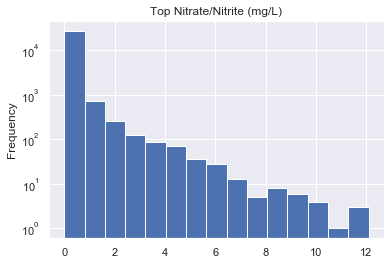

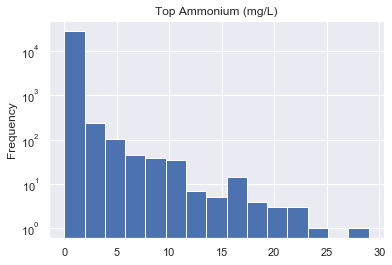

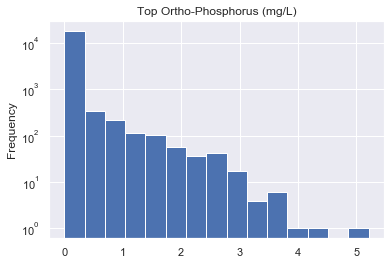

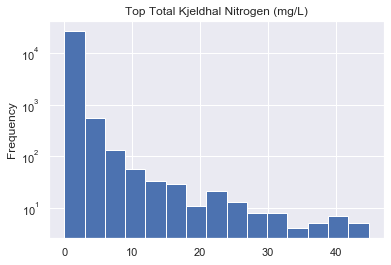

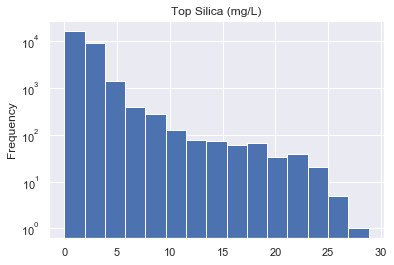

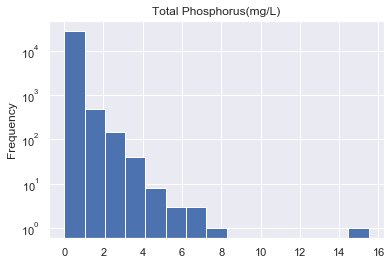

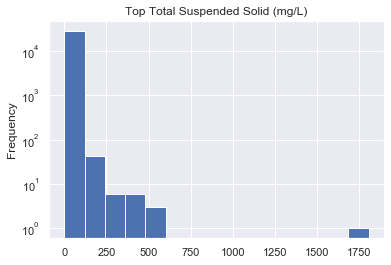

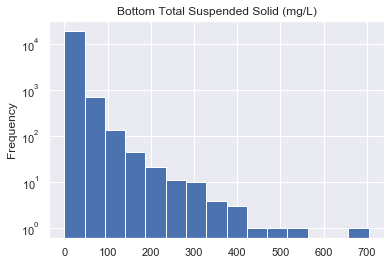

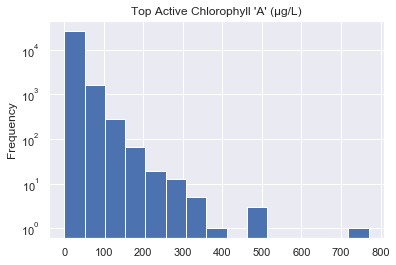

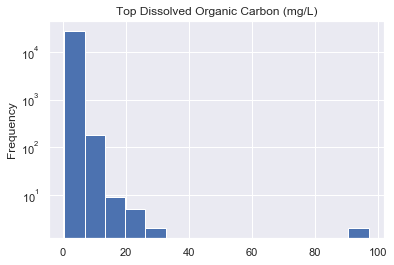

In [19]:
for col in wq_df_int_subset:
    _ = plt.figure()
    _ = wq_df_int[col].plot(kind='hist', bins=15)
    _ = plt.yscale('log')
    _ = plt.title(col)
    _ = plt.show()

- Questionable values: Total Phosphorous (max), Top TSS (max), Bottom TSS (max), Top Actiive Chlorophyll (max), Top Dissolved Organic Carbon

In [20]:
wq_df.nlargest(10, 'Total Phosphorus(mg/L)')['Total Phosphorus(mg/L)']

5735     15.500
10660     7.389
720       7.050
10641     6.900
16253     6.360
13518     5.630
24217     5.600
15119     5.500
8907      5.162
10049     4.830
Name: Total Phosphorus(mg/L), dtype: float64

In [21]:
wq_df.iloc[5735]

Sampling Location                                                                                 HC2
Sample Date                                                                       2011-06-27 00:00:00
Sample Time                                                                                  12:06:00
Weather Condition (Dry or Wet)                                                                      D
Top Sample Temperature (ºC)                                                                       NaN
Bottom Sample Temperature (ºC)                                                                    NaN
Site Actual Depth (ft)                                                                            7.4
Top Sample Depth(ft)                                                                              NaN
Bottom Sample Depth (ft)                                                                          NaN
Top Salinity  (psu)                                                               

Based on other measurements from this sampling event, this value does not appear to be an input error.

In [22]:
wq_df.nlargest(5, 'Top Total Suspended Solid (mg/L)')['Top Total Suspended Solid (mg/L)']

2843     1805.0
11396     536.0
1927      535.0
1412      488.0
18597     442.0
Name: Top Total Suspended Solid (mg/L), dtype: float64

In [23]:
wq_df = wq_df.drop(index=2843)

In [24]:
wq_df.nlargest(25, 'Bottom Total Suspended Solid (mg/L)')['Bottom Total Suspended Solid (mg/L)']

2450     704.4
22987    527.5
4352     482.0
600      442.0
10874    388.0
7348     386.0
18128    376.0
25873    345.0
9864     343.0
7679     338.8
2108     338.0
13064    327.0
951      326.6
13317    322.0
8569     320.0
8707     307.0
20507    306.8
9560     296.0
23541    289.0
8558     288.5
4488     288.0
16500    277.5
25225    276.0
13729    272.5
27787    257.0
Name: Bottom Total Suspended Solid (mg/L), dtype: float64

In [25]:
wq_df.nlargest(5, 'Top Active Chlorophyll \'A\' (µg/L)')['Top Active Chlorophyll \'A\' (µg/L)']

12907    770.00
20323    480.56
27708    466.00
29637    466.00
21918    404.70
Name: Top Active Chlorophyll 'A' (µg/L), dtype: float64

In [26]:
wq_df.nlargest(5, 'Top Dissolved Organic Carbon (mg/L)')['Top Dissolved Organic Carbon (mg/L)']

573      97.0
23319    95.8
28698    26.3
29676    26.3
28329    25.3
Name: Top Dissolved Organic Carbon (mg/L), dtype: float64

In [27]:
wq_df = wq_df.drop(index=[573, 23319])

In [28]:
wq_df.reset_index(drop=True, inplace=True)

In [29]:
row_lengths = defaultdict(int)

for i, row in wq_df.iterrows():
    row_lengths[row.notnull().sum()] += 1

<BarContainer object of 33 artists>

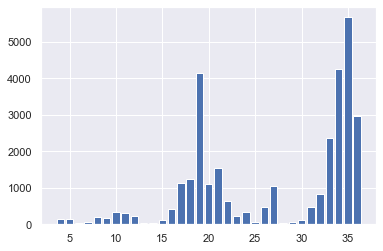

In [30]:
plt.bar(x=row_lengths.keys(), height=row_lengths.values())

I want to use only rows with at least 30 columns complete. This is to prevent my data from being overloaded with imputed data.

In [31]:
for i, row in wq_df.iterrows():
    if row.notnull().sum() < 30:
        wq_df = wq_df.drop(index=i)

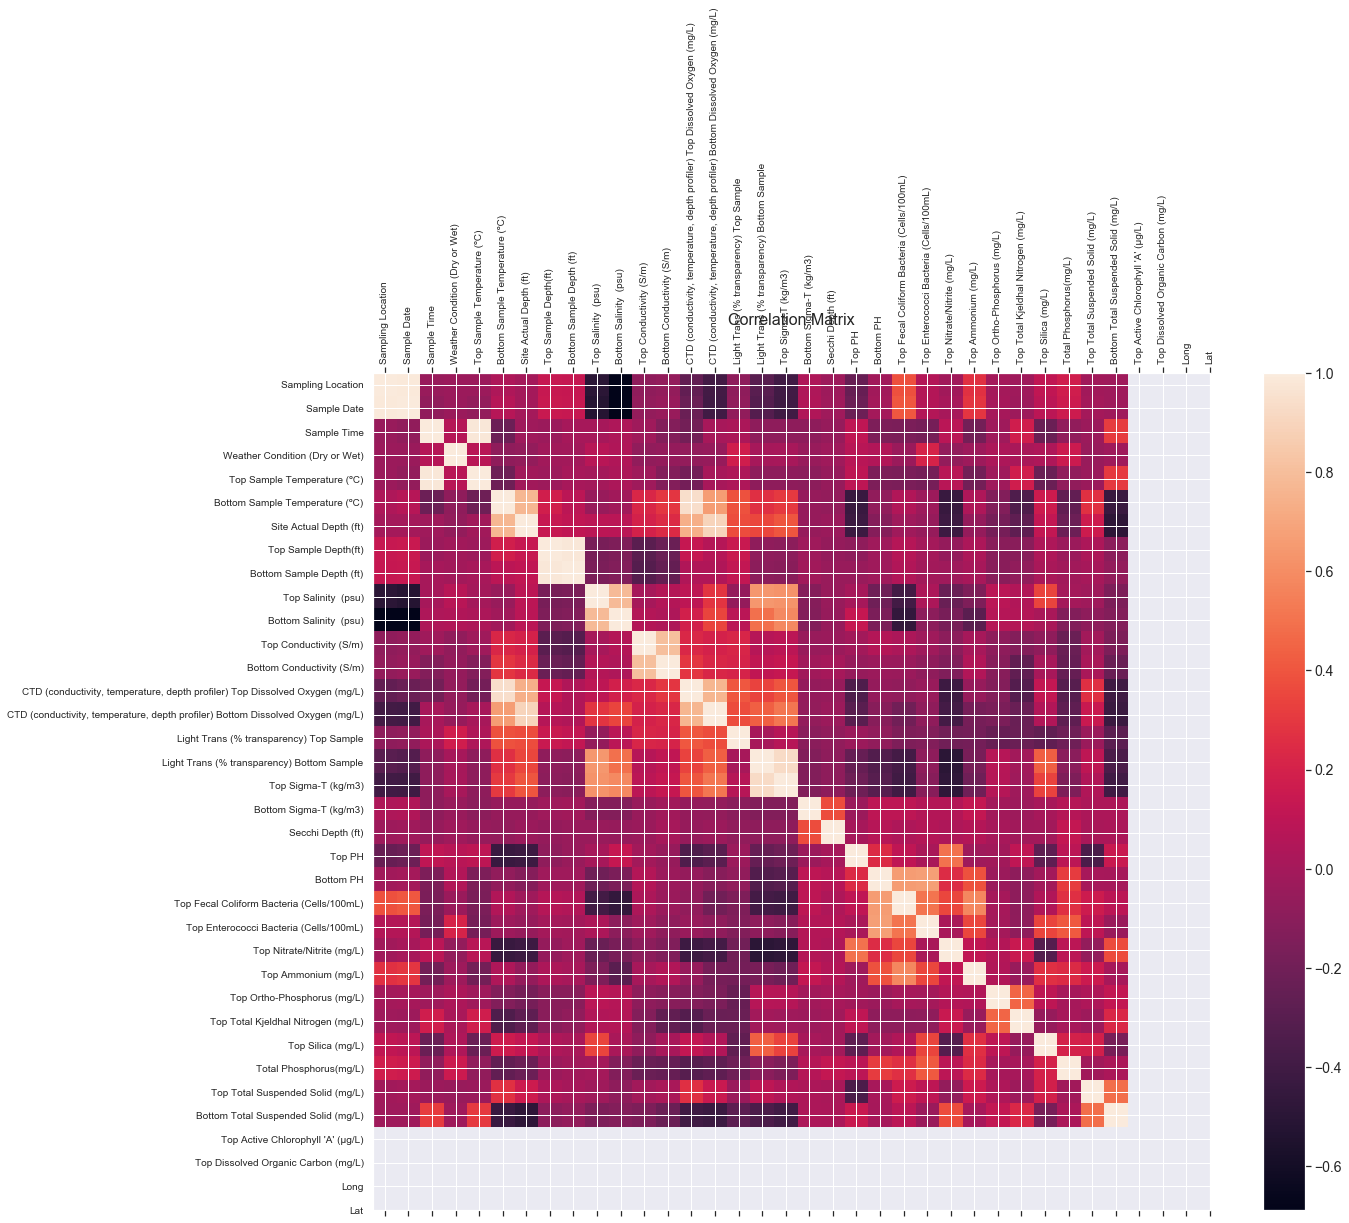

In [32]:
f = plt.figure(figsize=(19,15))
_ = plt.matshow(wq_df.corr(), fignum=f.number)
_ = plt.xticks(range(wq_df.shape[1]), wq_df.columns, fontsize=10, rotation=90)
_ = plt.yticks(range(wq_df.shape[1]), wq_df.columns, fontsize=10)
cb = plt.colorbar()
_ = cb.ax.tick_params(labelsize=14)
_ = plt.title('Correlation Matrix', fontsize=16)
_ = plt.show()

Next I will fill in blank values

In [33]:
ffill_df = pd.DataFrame()
for site in wq_df['Sampling Location'].unique():
    site_df = wq_df[wq_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='ffill')
    ffill_df = ffill_df.append(site_df)

In [34]:
final_df = pd.DataFrame()
for site in ffill_df['Sampling Location'].unique():
    site_df = ffill_df[ffill_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='bfill')
    final_df = final_df.append(site_df)

In [35]:
final_df = final_df.sort_index()
final_df = final_df.reset_index(drop=True)

Different parameters will serve different purposes in my analysis. Some measurements have standard limits that must not be exceeded. The rest of the columns will be potential indicators of poor water quality. I have outlined each column's limit/indicator status below:

Water Temperature = Indicator

Salinity = Indicator

Conductivity = Indicator

Dissolved Oxygen = 3.0 mg/L

Light Transparency = Indicator

Sigma-T = Indicator

Secchi Depth = Indicator

pH = 6.0 - 9.5

Fecal Coliform = 2000 cells/100mL

Enterococcus = 104 cells/100mL

Ammonia = 2.0 mg/L

Ortho-phosphate = 0.020 mg/L

Kjeldahl Nitrogen = 10.0 mg/L

Silica = Indicator

Total Suspended Solids = Indicator

Chlorophyll a = 30

Dissolved Organic Carbon = Indicator


In [82]:
# Make functions to 
def check_do(measure):
    if measure < 3.0:
        return 1
    else:
        return 0
    
def check_pH(measure):
    if measure > 9.5 or measure < 6.5:
        return 1
    else:
        return 0
    
def check_fecal(measure):
    if measure > 2000:
        return 1
    else:
        return 0
    
def check_enter(measure):
    if measure > 104:
        return 1
    else:
        return 0
    
def check_nitrate(measure):
    if measure > 10:
        return 1
    else:
        return 0

def check_ammonia(measure):
    if measure > 2:
        return 1
    else:
        return 0
    
def check_phosphate(measure):
    if measure > 0.020:
        return 1
    else:
        return 0
    
def check_chloro(measure):
    if measure > 30:
        return 1
    else:
        return 0
    
# Make a dictionary of each parameter with limits and assign its check function   
check_funcs = {'Top Ammonium (mg/L)':check_ammonia,
               'Top Active Chlorophyll \'A\' (µg/L)':check_chloro,
               'CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)':check_do,
               'Top Enterococci Bacteria (Cells/100mL)':check_enter,
               'Top Fecal Coliform Bacteria (Cells/100mL)':check_fecal,
#               'Top Nitrate/Nitrite (mg/L)':check_nitrate,
               'Top Total Kjeldhal Nitrogen (mg/L)':check_nitrate,
               'Top PH':check_pH,
               'Top Ortho-Phosphorus (mg/L)':check_phosphate
              }


In [83]:
fail_col = []
for col, func in check_funcs.items():
    new_col = col + ' Failure'
    fail_col.append(new_col)
    final_df[new_col] = final_df[col].apply(func)


In [100]:
final_df.loc[:, fail_col].sum()


Top Ammonium (mg/L) Failure                                                               73
Top Active Chlorophyll 'A' (µg/L) Failure                                               2450
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure      851
Top Enterococci Bacteria (Cells/100mL) Failure                                          1548
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                        928
Top Total Kjeldhal Nitrogen (mg/L) Failure                                                 4
Top PH Failure                                                                             6
Top Ortho-Phosphorus (mg/L) Failure                                                    16161
dtype: int64

I want to graph the number of failures for each standard over time.

In [ ]:
x = []
y = []
for date in final_df['Sample Date']:
    x.append(date)
    total = 0
    for col in fail_col:
        total += final_df[final_df['Sample Date'] == date][col].sum()
    y.append(total)
    print(date)

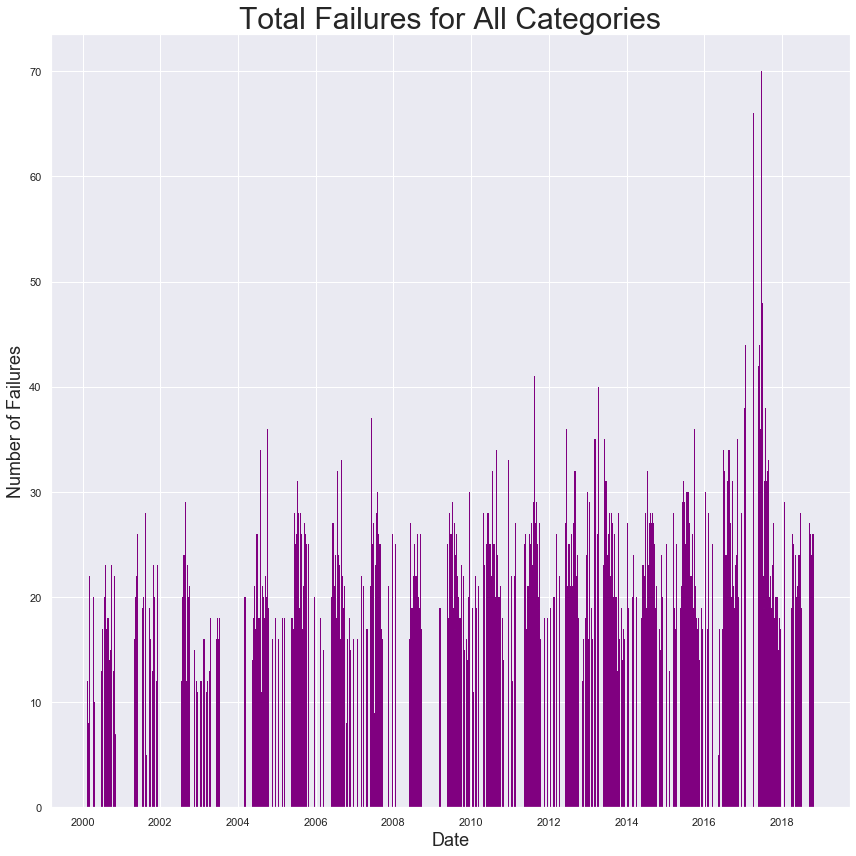

In [137]:
_ = plt.figure(figsize=(12, 12))
_ = plt.title('Total Failures for All Categories', fontsize=30)
_ = plt.xlabel('Date', fontsize=18)
_ = plt.ylabel('Number of Failures', fontsize=18)
_ = plt.bar(x=x, height=y, edgecolor='purple')
_ = plt.tight_layout()
_ = plt.show()

I want to graph total number of failures at each site

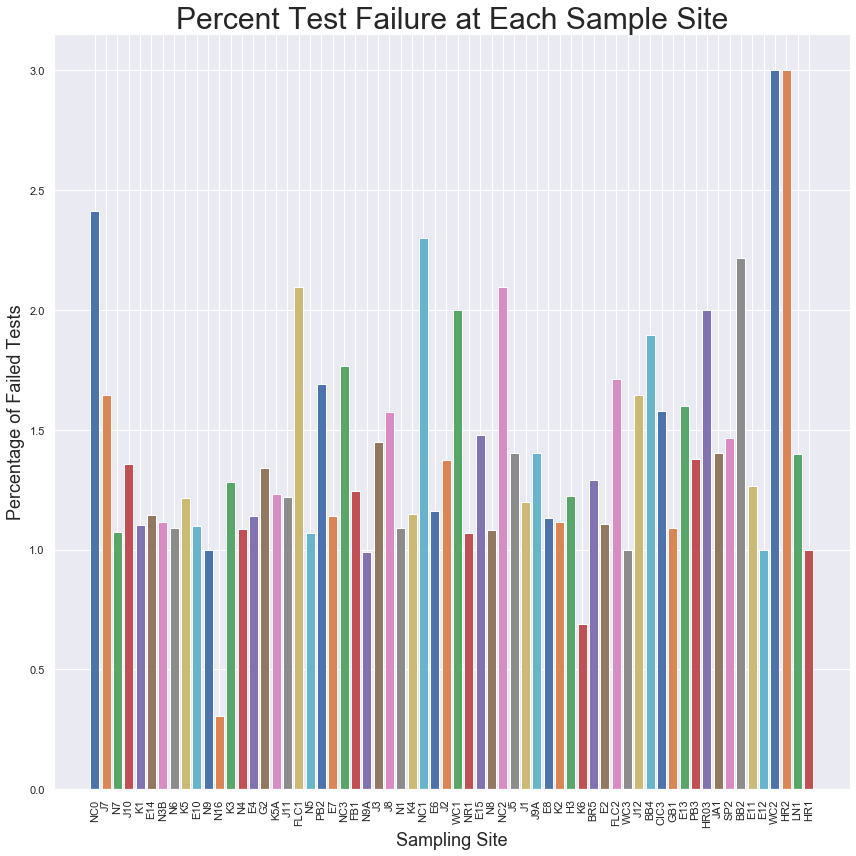

In [130]:
_ = plt.figure(figsize=(12, 12))

for location in final_df['Sampling Location'].unique():
    num = final_df[final_df['Sampling Location'] == location].loc[:, fail_col].sum().sum()
    den = final_df[final_df['Sampling Location'] == location].shape[0]
    ht = num / den

_ = plt.bar(x = location, 
            height = ht)

_ = plt.title('Percent Test Failure at Each Sample Site',
             fontsize=30)
_ = plt.xlabel('Sampling Site', fontsize=18)
_ = plt.ylabel('Percentage of Failed Tests', fontsize=18)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()